<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><h2>A1 | Unsupervised Analysis Assignment</h2>
<h4>DAT-5329 | Introduction to Machine Learning & AI</h4>
Lehlogonolo Mabetoa<br>
Hult International Business School<br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

# Introduction

This analysis investigates the impact of video content on audience engagement across various brand pages on Facebook. The dataset includes timestamps and engagement metrics such as reactions, comments, and shares. The objective is to uncover patterns and relationships that can inform content strategy, specifically evaluating whether videos drive higher engagement compared to other post types. Through exploratory data analysis, principal component analysis, and clustering, the project segments content into meaningful groups that can guide targeted marketing. Finally, a logistic regression model is developed to predict whether a post is a video based on its engagement characteristics.

In [1]:
########################################
# importing packages
########################################
import numpy as np  # mathematical essentials
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # fundamental data visualization
import seaborn as sns  # enhanced visualizations

# packages for unsupervised learning
from sklearn.preprocessing import StandardScaler  # standard scaler
from sklearn.decomposition import PCA  # pca
from scipy.cluster.hierarchy import dendrogram, linkage  # dendrograms
from sklearn.cluster import KMeans  # k-means clustering
from sklearn.preprocessing import power_transform
from sklearn.model_selection import RandomizedSearchCV  # hp tuning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer  # customizable scorer
from sklearn.preprocessing import StandardScaler  # data prep
from sklearn.metrics import confusion_matrix, roc_auc_score  # results analysis
from sklearn.cluster import KMeans  # k-means clustering
import sklearn.linear_model  # classification modeling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split # train/test split

########################################
# loading data and setting display options
########################################
# loading data
fb_df = pd.read_excel('./datasets/Facebook_Live_Data.xlsx')

# setting print options
from tabulate import tabulate

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# checking results
fb_df.head(n=10)

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,photo,2017-09-27 02:58:00,7,0,14,0,0,0,0,0
1,2,photo,2017-09-27 03:42:00,3,0,12,0,0,0,0,0
2,3,photo,2017-09-27 03:54:00,17,3,19,0,0,0,0,0
3,4,photo,2017-09-27 08:54:00,39,0,24,0,0,0,0,0
4,5,photo,2017-09-28 01:50:00,17,0,31,0,0,0,0,0
5,6,photo,2017-09-28 08:20:00,1,0,20,0,0,0,0,0
6,7,photo,2017-09-28 08:46:00,17,2,48,0,0,0,0,0
7,8,photo,2017-09-28 09:05:00,0,0,21,0,0,0,0,0
8,9,photo,2017-09-29 04:14:00,2,0,19,0,0,0,0,0
9,10,photo,2017-09-30 00:17:00,9,0,25,0,0,0,0,0


In [2]:
fb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_id       2362 non-null   int64         
 1   status_type     2362 non-null   object        
 2   time_published  2362 non-null   datetime64[ns]
 3   num_comments    2362 non-null   int64         
 4   num_shares      2362 non-null   int64         
 5   num_likes       2362 non-null   int64         
 6   num_loves       2362 non-null   int64         
 7   num_wows        2362 non-null   int64         
 8   num_hahas       2362 non-null   int64         
 9   num_sads        2362 non-null   int64         
 10  num_angrys      2362 non-null   int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 203.1+ KB


In [3]:
# looping for an easier subsetting input
for feature in fb_df:
    print(f'"{feature}" ,')

"status_id" ,
"status_type" ,
"time_published" ,
"num_comments" ,
"num_shares" ,
"num_likes" ,
"num_loves" ,
"num_wows" ,
"num_hahas" ,
"num_sads" ,
"num_angrys" ,


## Reactions Engagement Commentary
Likes emerge as the dominant form of surface-level engagement across all content types. However, videos stand out for their relatively high count of "love" reactions compared to photos and text, suggesting a deeper emotional response, even if not always in sheer volume.

An analysis of total reaction-based engagement—including likes, loves, wows, hahas, sads, and angrys—reveals an interesting parity: photos and videos generate nearly identical total reaction counts (222,920 for photos vs. 221,090 for videos). At face value, this could suggest that the two content formats are equally effective in evoking user sentiment.

However, this comparison becomes more nuanced when considering the production effort. Photo content is generally low-cost, low-effort, and easy to produce and distribute. In contrast, video content typically demands more resources—planning, filming, editing, and sometimes scripting—all of which involve greater financial and human capital investment.

This similarity in reaction volume prompts questions about return on investment (ROI): is the higher cost of video justified if it performs equally to photos in surface-level reactions? These results hint at a potential efficiency gap, where photos may offer a better ROI for pure reaction-based engagement, especially for brands with limited budgets.

Yet, reactions don’t tell the full story—which is where deeper engagement becomes more revealing.

╒═══════════════╤════════════════╤══════════════╤═══════════════════════════╕
│ status_type   │   num_comments │   num_shares │   total_deeper_engagement │
╞═══════════════╪════════════════╪══════════════╪═══════════════════════════╡
│ photo         │          30185 │         3998 │                     34183 │
├───────────────┼────────────────┼──────────────┼───────────────────────────┤
│ text          │          12681 │         1015 │                     13696 │
├───────────────┼────────────────┼──────────────┼───────────────────────────┤
│ video         │         504156 │        88371 │                    592527 │
╘═══════════════╧════════════════╧══════════════╧═══════════════════════════╛


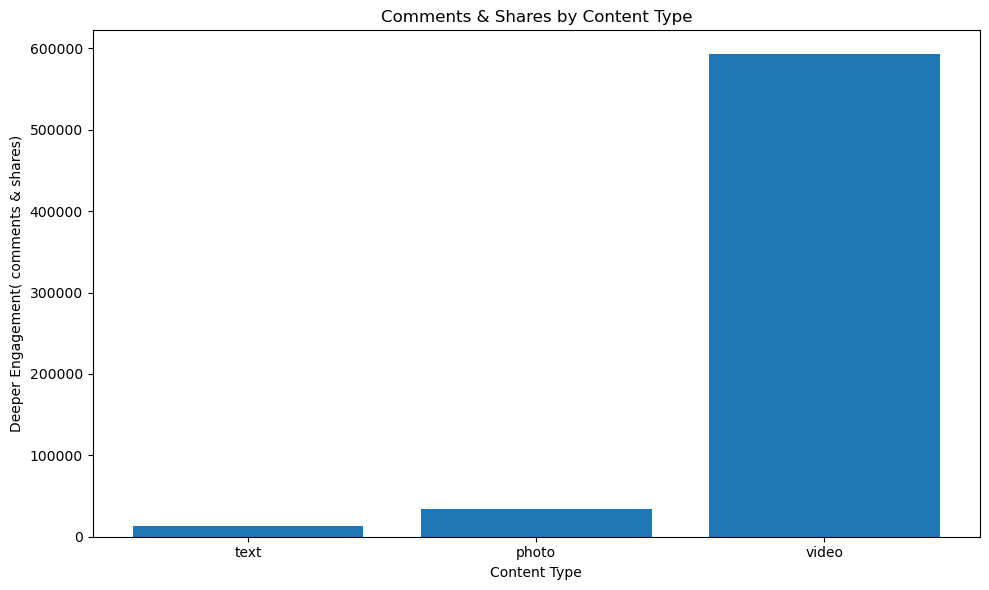

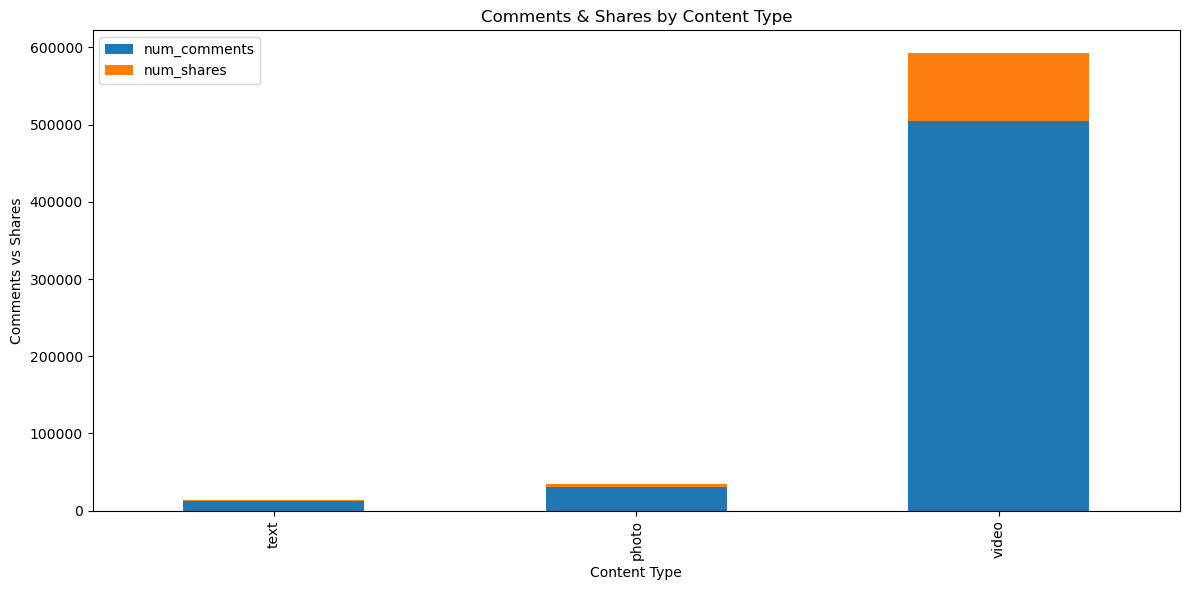

In [4]:
##########################################
## # Subsetting for comments and shares ##
##########################################


deeper_engagement = ['num_comments', 'num_shares']
deeper_totals = fb_df.groupby('status_type')[deeper_engagement].sum(
)  # Grouping the observations by status type

deeper_totals['total_deeper_engagement'] = deeper_totals.sum(
    axis=1)  # Creating a new column

deeper_totals_sorted = deeper_totals.sort_values(
    by='total_deeper_engagement',
    ascending=True)  # organising the data by values

##########################################
##    Resetting the indexes            ##
##########################################
# Resetting the indexes
deeper_totals.reset_index(inplace=True)

# Display the DataFrame as a table for review
print(
    tabulate(
        deeper_totals.values.tolist(),  # Visualising totals in a table
        headers=deeper_totals.columns.tolist(
        ),  # Setting headers as df columns
        tablefmt='fancy_grid'))  # Type of table

# Bar plot for total_deeper_engagement
plt.figure(figsize=(10, 6))
plt.bar(deeper_totals_sorted.index,
        deeper_totals_sorted['total_deeper_engagement'])
plt.title('Comments & Shares by Content Type')
plt.xlabel('Content Type')
plt.ylabel('Deeper Engagement( comments & shares)')
plt.tight_layout()
plt.show()


################################################
## # Stacked Bar plot for comments and shares ##
################################################


deeper_totals_sorted[deeper_engagement].plot(kind='bar',
                                             figsize=(12, 6),
                                             stacked=True)
plt.title('Comments & Shares by Content Type')  # Plot title
plt.xlabel('Content Type')  # Labeling axis
plt.ylabel('Comments vs Shares')  # Labeling axis
plt.tight_layout()
plt.show()

## Deeper Engagement Commentary (Comments & Shares)
On social platforms like Facebook, engagement exists on a spectrum—from passive acknowledgments to high-effort, socially visible interactions. Reactions like "likes" or "wows" represent low-effort signals of interest. In contrast, comments and shares reflect intentional and deeper forms of participation.

For a more nuanced analysis, we segmented engagement into surface-level reactions and deeper actions. This helps avoid misleading conclusions that could arise from evaluating engagement through a single aggregated metric. A post may generate many likes but still fail to inspire conversation or sharing, indicating limited resonance or relatability.

By isolating deeper engagement, we uncover a striking distinction: videos dominate. They generate a total of 592,527 comments and shares, compared to 34,183 for photos and 13,696 for text. This outsized performance suggests that videos are significantly more effective at initiating discussions and encouraging content dissemination.

Comments often reflect curiosity, emotional involvement, or debate—indicators that a user is mentally engaged with the content. Shares are even more powerful; they indicate the user is willing to affiliate their identity with the content and broadcast it to their own network.

This level of user behavior is more difficult to earn and far more valuable to brands. It implies trust, relatability, and alignment with the brand's message—factors that fuel organic reach and long-term customer loyalty.

While videos may not dominate the reaction counts alone, they far surpass other formats in these deeper metrics. In essence, videos create conversations, not just acknowledgments. This insight is critical for brands aiming to build engaged communities rather than passive audiences.

+-------------+-----------+-----------+----------+-----------+----------+------------+----------------------------+
| status_type | num_likes | num_loves | num_wows | num_hahas | num_sads | num_angrys | total_reactions_engagement |
+-------------+-----------+-----------+----------+-----------+----------+------------+----------------------------+
|    photo    |  220453   |   1256    |   787    |    154    |   198    |     72     |           222920           |
|    text     |  147606   |    465    |   364    |    37     |   126    |     5      |           148603           |
|    video    |  190020   |   27164   |   1856   |   1520    |   327    |    203     |           221090           |
+-------------+-----------+-----------+----------+-----------+----------+------------+----------------------------+


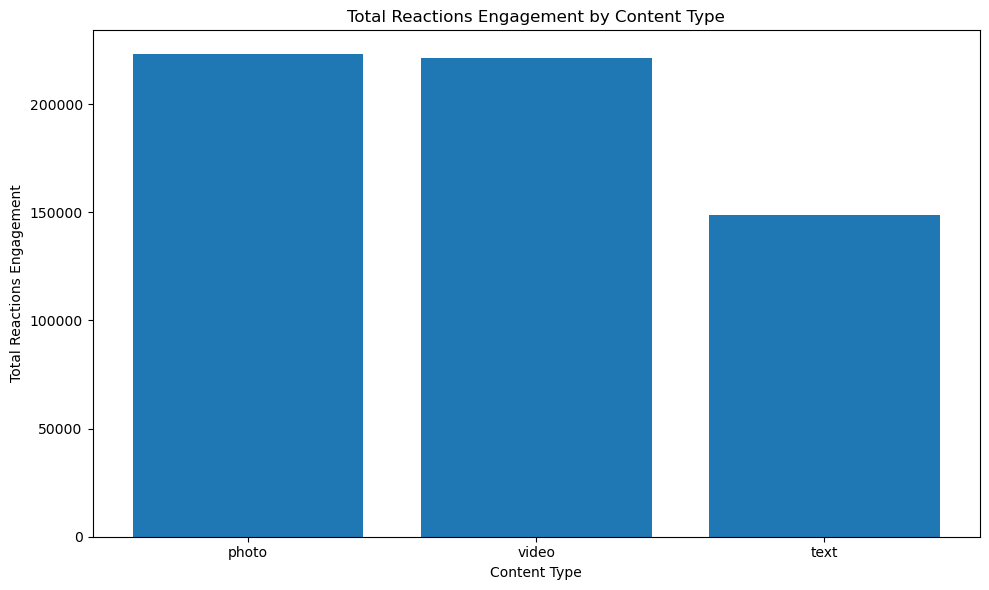

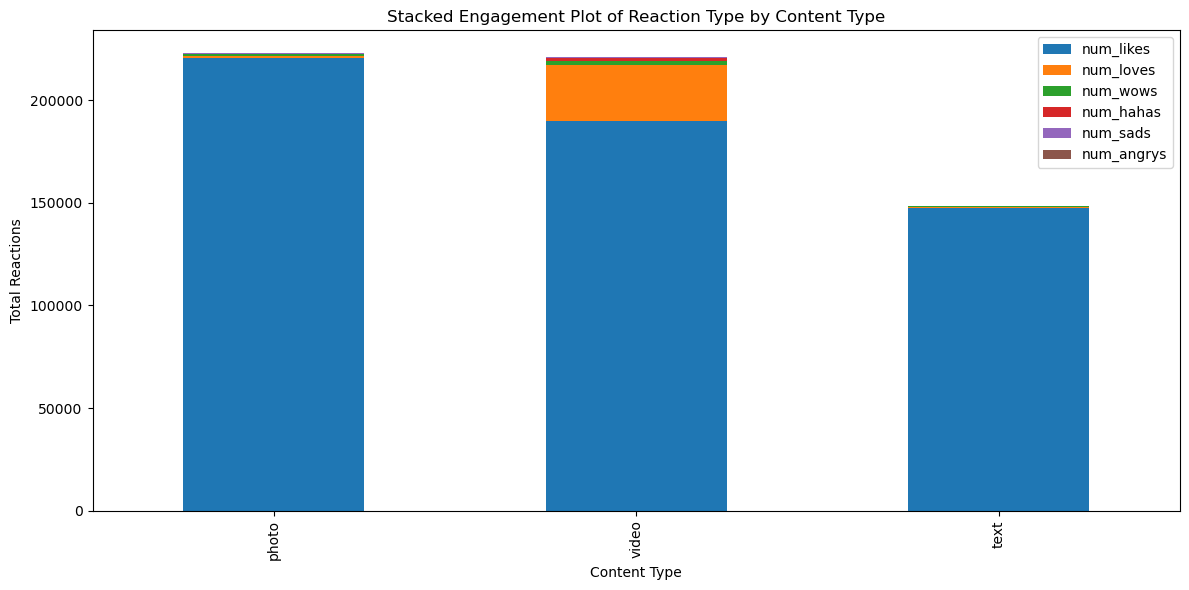

In [5]:

################################################
## # Stacked Bar plot for Reactions           ##
################################################

# Recomputing reactions_summary and engagement_totals to ensure consistency
reaction_columns = [
    'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys'
]

reactions_summary = fb_df.groupby('status_type')[reaction_columns].sum()

reactions_summary['total_reactions_engagement'] = reactions_summary.sum(axis=1)

reactions_summary_sorted = reactions_summary.sort_values(
    by='total_reactions_engagement', ascending=False)

# Resetting the indexes
reactions_summary.reset_index(inplace=True)

print(
    tabulate(
        reactions_summary.values.tolist(),  # Visualising totals in a table
        headers=reactions_summary.columns.tolist(
        ),  # Setting headers as df columns
        tablefmt='pretty'))  # Type of table

# Plot total reactions engagement
plt.figure(figsize=(10, 6))
plt.bar(reactions_summary_sorted.index,
        reactions_summary_sorted['total_reactions_engagement'])
plt.title('Total Reactions Engagement by Content Type')
plt.xlabel('Content Type')
plt.ylabel('Total Reactions Engagement')
plt.tight_layout()
plt.show()


######################################################
## # Stacked bar plot for individual reaction types ##
######################################################


reactions_summary_sorted[reaction_columns].plot(kind='bar',
                                                figsize=(12, 6),
                                                stacked=True)
plt.title('Stacked Engagement Plot of Reaction Type by Content Type')
plt.xlabel('Content Type')
plt.ylabel('Total Reactions')
plt.tight_layout()
plt.show()

### Content Type Distribution and Its Implication
<p>Using value_counts() on status_type, we observe that: <p><p>

    
Photos are the most common content type in the dataset, comprising the majority of posts.

Videos, though significantly fewer in number, consistently outperform photos in deeper engagement metrics such as comments and shares.

This suggests that video content, while resource-intensive to produce, has a higher engagement yield per post in terms of meaningful interaction.

Text posts, however, are substantially underrepresented, with only 329 observations compared to thousands of photo and video posts.

This imbalance in representation skews the comparative analysis to some degree:

The low engagement performance of text posts may be partially attributed to their limited presence in the dataset rather than an inherent lack of appeal.

As a result, while they appear to be the weakest format in terms of both reactions and deeper interactions, this outcome should be interpreted with caution due to the small sample size.

Overall, the data suggests that videos are a high-impact format, particularly in driving deeper engagement through comments and shares. However, the strong performance of photos—both in reactions and meaningful interactions—should not be overlooked. Photos consistently generate substantial engagement, indicating that they remain an effective and efficient format. The caveat is that there are proportionally more photos in the dataset as well

In [6]:
fb_df['status_type'].value_counts() # Aggregating by type

status_type
photo    1313
video     720
text      329
Name: count, dtype: int64

In [7]:
########################################################
## Extracting from time_published into separate times ##
########################################################
#Extract month, day of week, and hour (time of day)
fb_df['month'] = fb_df['time_published'].dt.month
fb_df['hour'] = fb_df['time_published'].dt.hour
fb_df['Day'] = fb_df['time_published'].dt.dayofweek # Monday=0, Sunday=6
fb_df

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,month,hour,Day
0,1,photo,2017-09-27 02:58:00,7,0,14,0,0,0,0,0,9,2,2
1,2,photo,2017-09-27 03:42:00,3,0,12,0,0,0,0,0,9,3,2
2,3,photo,2017-09-27 03:54:00,17,3,19,0,0,0,0,0,9,3,2
3,4,photo,2017-09-27 08:54:00,39,0,24,0,0,0,0,0,9,8,2
4,5,photo,2017-09-28 01:50:00,17,0,31,0,0,0,0,0,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2358,video,2023-08-25 07:01:00,0,6,33,0,0,0,0,0,8,7,4
2358,2359,video,2023-08-25 07:19:00,981,108,165,37,1,3,2,0,8,7,4
2359,2360,photo,2023-08-25 08:10:00,0,0,24,0,1,0,0,0,8,8,4
2360,2361,photo,2023-08-25 12:06:00,0,0,5,0,0,0,0,0,8,12,4


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<strong>User-Defined Functions</strong><br>
Scree_plot 

In [8]:
########################################
# scree_plot
########################################
def scree_plot(pca_object, export = False):
    # building a scree plot

    
    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)


    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth = 2,
             marker = 'o',
             markersize = 10,
             markeredgecolor = 'black',
             markerfacecolor = 'grey')

    plt.axvline(x=3,
            color='red',
            linestyle='--',
            linewidth=2,
            label='Cutoff')
    
    # setting more plot options
    plt.title('Scree Plot')
    plt.xlabel('PCA feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)

    if export == True:
    
        # exporting the plot
        plt.savefig('./analysis_images/top_customers_correlation_scree_plot.png')
        
    # displaying the plot
    plt.show()


########################################
# unsupervised_scaler
########################################
def scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [9]:
########################################
# subsetting the dataframes
########################################
fb_cont = fb_df[[
     "num_comments", "num_shares", "num_likes", "num_loves",
    "num_wows", "num_hahas", "num_sads", "num_angrys"
]]

########################################
# transforming the df with yeo-johnson
########################################

fb_transformed = power_transform(X = fb_cont,
                                       method = 'yeo-johnson',
                                       standardize = True)

########################################
# converting into dataframe for later
########################################
fb_transformed = pd.DataFrame(data = fb_transformed,
                                     columns = list(fb_cont.columns))


In [10]:
########################################
# # applying the UDF scaler function
########################################
#fb_transformed
fb_cont_scaled = scaler(df=fb_transformed)


########################################
# checking pre- and post-scaling variance
########################################
print(np.var(fb_cont), '\n\n')
print(np.var(fb_cont_scaled))

num_comments    724785.643605
num_shares       15294.038713
num_likes       237480.965188
num_loves         1668.014855
num_wows            78.066413
num_hahas           16.854181
num_sads             3.474841
num_angrys           0.800511
dtype: float64 


num_comments    1.0
num_shares      1.0
num_likes       1.0
num_loves       1.0
num_wows        1.0
num_hahas       1.0
num_sads        1.0
num_angrys      1.0
dtype: float64


/Users/hloney/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


#### Correlation heatmap

The correlation heatmap shows a healthy mix of low to moderate correlations among the engagement variables, which is ideal for PCA. A few variables, such as num_loves and num_shares, are highly correlated (0.83), suggesting some redundancy in emotional engagement behavior. However, most variables exhibit low correlations, indicating they capture distinct user interactions. This structure allows PCA to meaningfully reduce dimensionality without losing critical variance across features. Any remaining skew or imbalance in feature scales is corrected in the following steps through standardization, ensuring each variable contributes equally to the PCA computation.

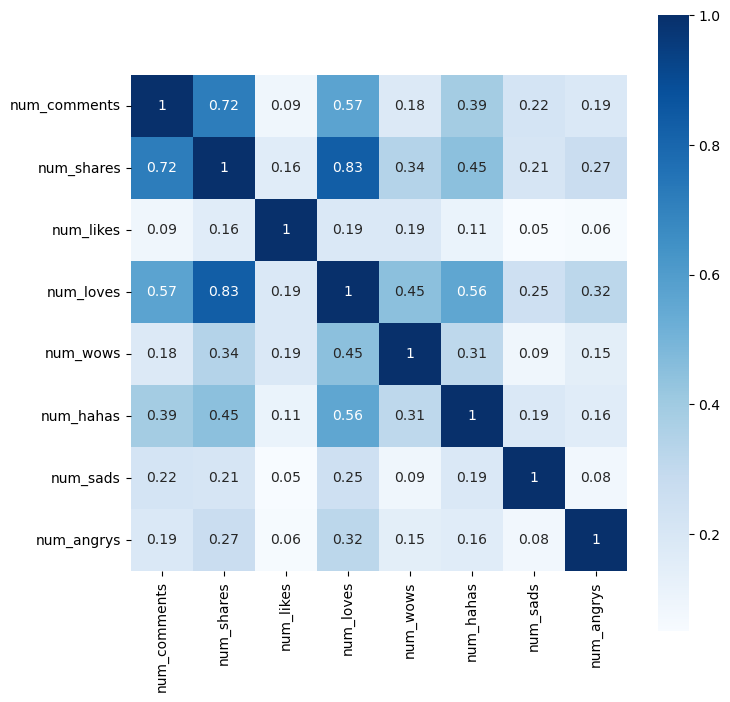

In [11]:
########################################
# # setting plot size
########################################

fig, ax = plt.subplots(figsize = (8, 8))


# developing a correlation matrix object
df_corr = fb_cont.corr().round(decimals = 2) # try again w/ customers_df or. the scaled data


# creating a correlation heatmap
sns.heatmap(data   = df_corr,
            cmap   = 'Blues',
            square = True,
            annot  = True)


# rendering the heatmap
plt.show()

In [12]:
########################################
# df skew before scaling
########################################

fb_cont_scaled.skew()

num_comments    0.265498
num_shares      0.754833
num_likes       0.003079
num_loves       0.897173
num_wows        1.417676
num_hahas       1.992861
num_sads        2.775965
num_angrys      3.834799
dtype: float64

In [13]:
########################################
# #df skew after scaling
########################################

fb_cont.skew()

num_comments     6.258604
num_shares       4.632488
num_likes        3.450364
num_loves        5.434574
num_wows        19.819234
num_hahas       16.543121
num_sads        17.430728
num_angrys      22.684473
dtype: float64

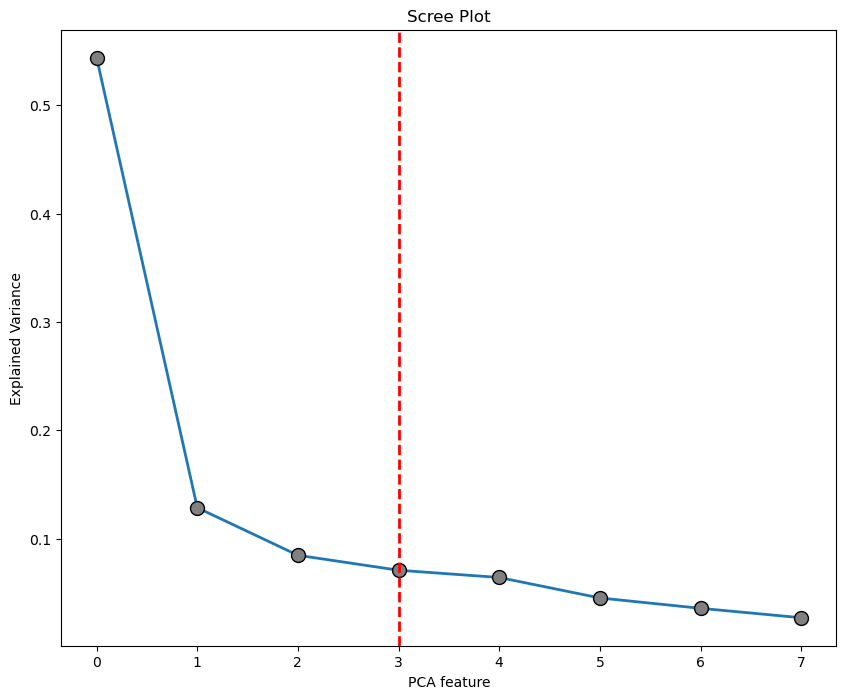

In [14]:
########################################
# Initial PCA
########################################
pca = PCA(n_components = None,
          random_state = 702)


########################################
# FITTING and TRANSFORMING the scaled data
########################################

facebook_pca = pca.fit_transform(fb_cont_scaled)


# calling the scree_plot function
scree_plot(pca_object = pca)

## Principal Components (PCA) Rationale
To uncover latent patterns in the social media engagement data, Principal Component Analysis (PCA) was applied to the scaled numeric features. A scree plot was generated to visualize the explained variance across components, helping determine an optimal cutoff point for dimensionality reduction.

While the elbow method typically suggests retaining components up to the point where the curve begins to flatten, applying this strictly would result in preserving only the first 2–3 components—capturing just around 70% of the total variance. Given the complexity and variability in user engagement behavior, this threshold was deemed too limiting.

Instead, a more flexible and context-aware decision was made to retain the first 4 principal components, as indicated by the red vertical line on the scree plot. These four components together explain approximately 80% of the total variance, striking a balance between interpretability and preserving meaningful information.

By keeping these 4 components, we maintain a robust representation of the original feature space while simplifying the dataset for subsequent clustering and modeling. This approach allows us to capture the most significant variance in engagement patterns without overwhelming the analysis with noise or redundancy.



In [15]:
################################################################
# # INSTANTIATING a new model using the 4 principal components
################################################################

pca_4 = PCA(n_components = 4,
          random_state = 702)


# FITTING and TRANSFORMING the fb_cont_scaled
facebook_pca_4 = pca_4.fit_transform(fb_cont_scaled)

# comparing dimensions of each DataFrame
print("Original shape:", fb_cont_scaled.shape)
print("PCA shape     :", facebook_pca_4.shape)

Original shape: (2362, 8)
PCA shape     : (2362, 4)


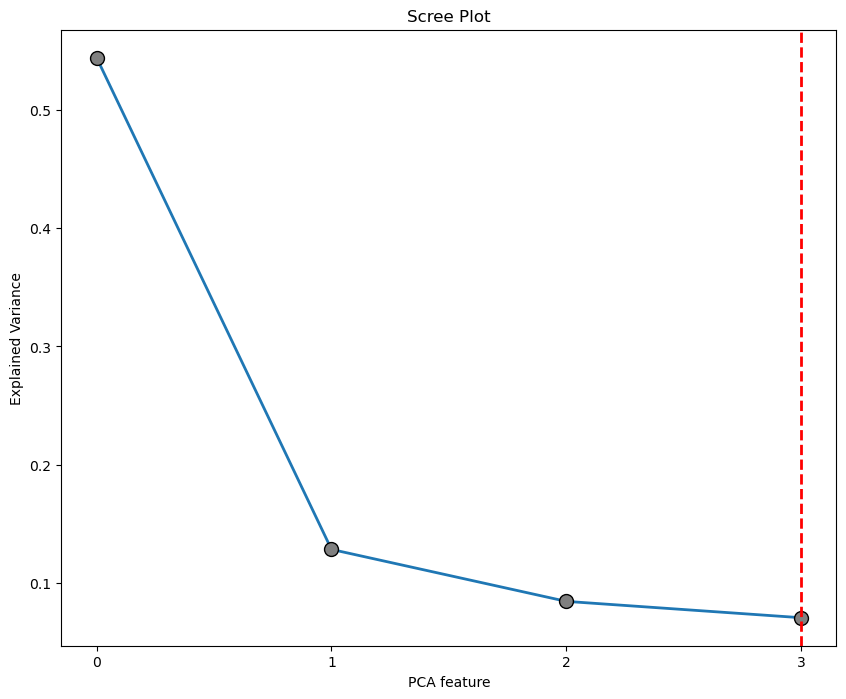

In [16]:
scree_plot(pca_object = pca_4)

In [17]:
###########################
# component number counter
##########################

# component number counter
component_number = 0

# looping over each principal component
for variance in pca_4.explained_variance_ratio_:
    component_number += 1
    
    print(f"PC {component_number}: {variance.round(3)}")
      
    

PC 1: 0.544
PC 2: 0.129
PC 3: 0.085
PC 4: 0.071


In [18]:
#######################################
# transposing pca components (pc = MAX)
#######################################

factor_loadings = pd.DataFrame(np.transpose(pca.components_))

# naming rows as original features
factor_loadings = factor_loadings.set_index(fb_cont_scaled.columns)



##################
### 3 PC Model ###
##################
# transposing pca components (pc = 4)
factor_loadings_4 = pd.DataFrame(np.transpose(pca_4.components_))


# naming rows as original features
factor_loadings_4 = factor_loadings_4.set_index(fb_cont_scaled.columns)


# checking the results
print(f"""
MAX Components Factor Loadings
------------------------------
{factor_loadings.round(2)}


Four Retained Factor Loadings
------------------------------
{factor_loadings_4.round(2)}
""")




MAX Components Factor Loadings
------------------------------
                 0     1     2     3     4     5     6     7
num_comments  0.40  0.29 -0.21  0.01 -0.08 -0.14  0.38  0.73
num_shares    0.39  0.15  0.09 -0.00 -0.42  0.67 -0.43  0.05
num_likes     0.30  0.57 -0.51 -0.07  0.21 -0.19 -0.20 -0.45
num_loves     0.41  0.03  0.34  0.06 -0.09  0.13  0.68 -0.48
num_wows      0.34  0.08  0.59 -0.05  0.64 -0.10 -0.29  0.15
num_hahas     0.37 -0.29  0.13 -0.04 -0.50 -0.65 -0.28 -0.09
num_sads      0.30 -0.45 -0.33  0.73  0.25  0.09 -0.05 -0.01
num_angrys    0.28 -0.53 -0.32 -0.68  0.22  0.17  0.07 -0.01


Four Retained Factor Loadings
------------------------------
                 0     1     2     3
num_comments  0.40  0.29 -0.21  0.01
num_shares    0.39  0.15  0.09 -0.00
num_likes     0.30  0.57 -0.51 -0.07
num_loves     0.41  0.03  0.34  0.06
num_wows      0.34  0.08  0.59 -0.05
num_hahas     0.37 -0.29  0.13 -0.04
num_sads      0.30 -0.45 -0.33  0.73
num_angrys    0.28 -0.53 -0.3

## Interpreting Principal Components

####  PCA_1: More Deeper Interactions & Reactions

Positive Spectrum:
This component is positively associated with all major engagement types—comments, shares, likes, loves, and even “wow” and “haha” reactions. High values on this component suggest posts that generate broad, active user engagement across both surface-level and deeper metrics. These posts likely succeed in attracting attention and prompting participation from the audience. The balanced mix of reactions and interactions points to high-performing, emotionally engaging content.

Negative Spectrum:
There are no strong negative loadings on this component, meaning it doesn’t strongly identify a contrasting type of post. However, posts with low scores may be those that fail to generate meaningful engagement across the board. Such content might be overlooked, unremarkable, or posted at suboptimal times. In practice, these could be lower-effort posts that do not resonate with audiences.


#### PCA_2: Positive Deep Interactions Over Negative Reactions

Positive Spectrum:
This side reflects content that receives deeper engagement such as likes, shares, and comments, but avoids triggering negative emotional responses like sadness or anger. A high score indicates a post that stimulates positive community interaction while maintaining emotional safety. These posts likely convey uplifting, celebratory, or relatable messages that users feel comfortable supporting and sharing.

Negative Spectrum:
The strong negative loadings on num_angrys, num_sads, and num_hahas suggest this end of the spectrum is associated with content that provokes frustration, sadness, or potentially ridicule. Posts scoring low on this component might be controversial or emotionally triggering, sparking more reactive than proactive engagement. For brands, these posts might drive traffic but could risk reputational harm if misinterpreted.

#### PCA_3: Surprise Reactions Over Likes

Positive Spectrum:
This component is marked by high levels of “wow,” “love,” and “haha” reactions, suggesting that users respond with curiosity, delight, or amusement. These posts surprise or emotionally nudge audiences, prompting stronger-than-average reactions. However, they still primarily sit within the passive engagement layer, indicating content that grabs attention but doesn’t always lead to further action. It’s eye-catching but may or may not convert into comments or shares.

Negative Spectrum:
The negative end leans heavily on likes — the most common but least effortful form of engagement. Low scores here may reflect posts that are acknowledged without emotional intensity, meaning they blend into the scroll rather than standing out. While consistent “like” performance can indicate content relevance, it doesn’t provide the same strategic value as posts that elicit deeper interaction or stronger sentiment.


#### PCA_4: Emotional Polarity – Sadness Over Anger

Positive Spectrum:
This side of the component is defined by high positive loadings on sadness reactions. It’s important to note that while the posts elicit a strong emotional response, they don’t appear to prompt deeper engagement — there is no corresponding increase in comments or shares. This signals content that is emotionally impactful but passively consumed, where audiences feel something but aren’t moved to take public or interactive action.

Negative Spectrum:

The negative end is strongly defined by anger reactions, positioning this side as reflective of outrage-inducing or polarizing content. Such posts likely provoke strong emotional disapproval or frustration but, again, don’t drive active participation like commenting or sharing, it could be rage-baiting or click-baiting content. Despite the intensity of the emotion, the lack of deeper engagement indicates that users may be reacting impulsively rather than thoughtfully interacting. This spectrum as a whole captures content that resonates emotionally—but silently. It may be seen and felt, but it doesn't spark conversation or virality, limiting its strategic value in content aimed at community-building or organic amplification.

In [19]:
#######################################
# naming each principal component
#######################################

factor_loadings_4.columns = [
    'More Deeper Interactions & Reactions',
    'Positive Deep Interactions Over Negative Reactions',
    'Surprise Reactions Over Likes',
    'Emotional Polarity:Sadness Over Anger'

]

factor_loadings_4.round(decimals =2)

,More Deeper Interactions & Reactions,Positive Deep Interactions Over Negative Reactions,Surprise Reactions Over Likes,Emotional Polarity:Sadness Over Anger
num_comments,0.40,0.29,-0.21,0.01
num_shares,0.39,0.15,0.09,-0.00
num_likes,0.30,0.57,-0.51,-0.07
num_loves,0.41,0.03,0.34,0.06
num_wows,0.34,0.08,0.59,-0.05
num_hahas,0.37,-0.29,0.13,-0.04
num_sads,0.30,-0.45,-0.33,0.73
num_angrys,0.28,-0.53,-0.32,-0.68


# PCA preparation for K-Means Clustering

In [20]:
############################################
# analyzing factor strengths per customer
############################################

factor_loadings = pca_4.transform(fb_cont_scaled)


############################################
# converting to a DataFrame
############################################

factor_loadings_df = pd.DataFrame(factor_loadings)


# renaming columns
factor_loadings_df.columns = factor_loadings_4.columns


# checking the results
factor_loadings_df.head(n = 5)

,More Deeper Interactions & Reactions,Positive Deep Interactions Over Negative Reactions,Surprise Reactions Over Likes,Emotional Polarity:Sadness Over Anger
0,-1.235813,-0.160084,-0.141957,-0.012894
1,-1.418665,-0.322208,-0.017235,-0.008975
2,-0.414832,0.280058,-0.164039,-0.026190
3,-0.870796,0.209307,-0.436576,-0.030796
4,-0.949142,0.202659,-0.445807,-0.042955


In [21]:

############################################
## applying the unsupervised_scaler function
############################################

pca_rescaled = scaler(df = factor_loadings_df)


# checking pre- and post-scaling variance
print(np.var(factor_loadings_df), '\n\n')
print(np.var(pca_rescaled))

More Deeper Interactions & Reactions                  4.350872
Positive Deep Interactions Over Negative Reactions    1.028333
Surprise Reactions Over Likes                         0.677176
Emotional Polarity:Sadness Over Anger                 0.566711
dtype: float64 


More Deeper Interactions & Reactions                  1.0
Positive Deep Interactions Over Negative Reactions    1.0
Surprise Reactions Over Likes                         1.0
Emotional Polarity:Sadness Over Anger                 1.0
dtype: float64


/Users/hloney/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [22]:
pca_rescaled.info() # Checking 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   More Deeper Interactions & Reactions                2362 non-null   float64
 1   Positive Deep Interactions Over Negative Reactions  2362 non-null   float64
 2   Surprise Reactions Over Likes                       2362 non-null   float64
 3   Emotional Polarity:Sadness Over Anger               2362 non-null   float64
dtypes: float64(4)
memory usage: 73.9 KB


## Agglomerative Clustering

In [23]:
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents t

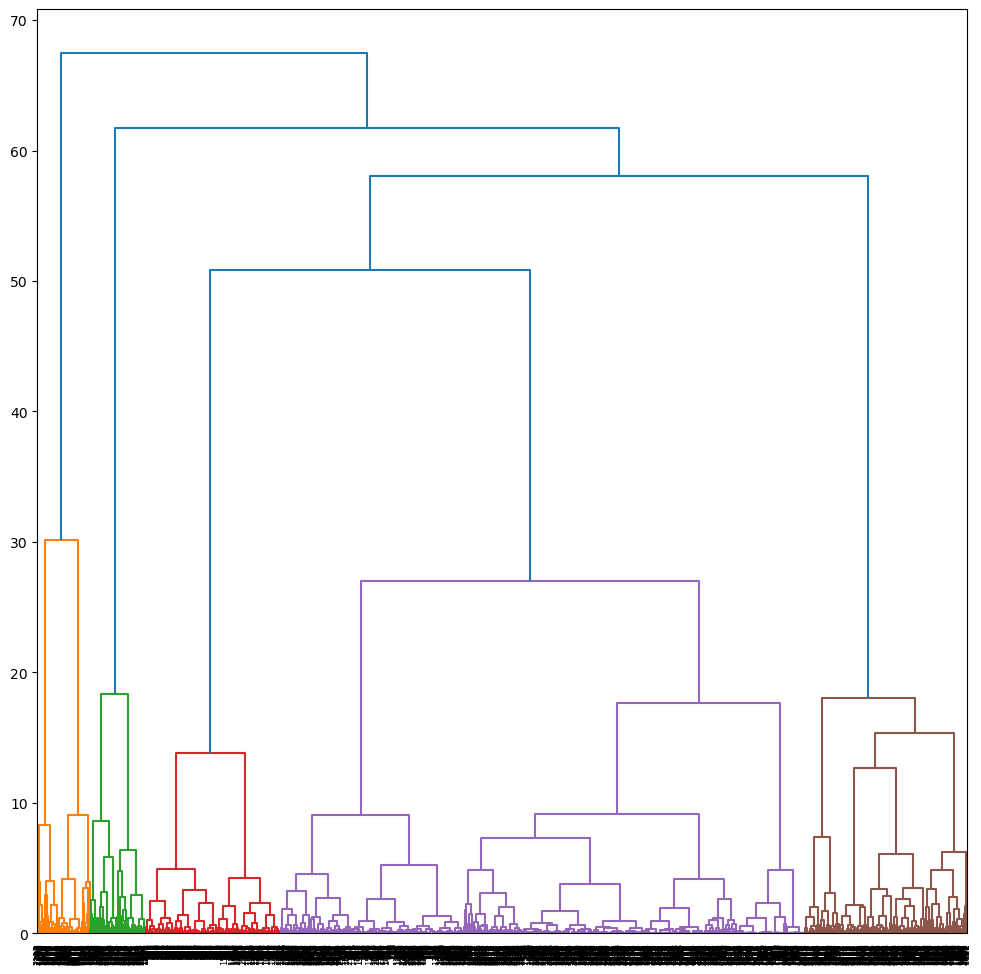

In [24]:
############################################
# grouping data based on Ward distance
############################################

standard_mergings_ward = linkage(y = pca_rescaled,
                                 method = 'ward',
                                 optimal_ordering = True)


# setting plot size
fig, ax = plt.subplots(figsize=(12, 12))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation  = 90       ,
           leaf_font_size = 6        )


# rendering the plot
plt.show()

## K-Means Segmentation & Cluster Selection Rationale


K-means clustering was applied using the four retained principal components from PCA, which collectively captured over 80% of the engagement variance. These components reflect key behavioral patterns across user interactions, from deeper engagement to emotional polarity. Before clustering, the data was scaled.

To determine the ideal number of clusters, a dendrogram using Ward’s linkage revealed a clear break at four clusters. This was further validated by applying K-means with k=4, which resulted in a balanced segmentation: Cluster 0 (1,268 posts), Cluster 2 (819), and two smaller but distinct groups — Cluster 3 (141) and Cluster 1 (134). The fact that each cluster has a meaningful number of observations suggests the structure is not random or fragmented.

This choice balances interpretability with diversity — capturing a range of content behaviors while avoiding over-segmentation. Segmenting into four groups allows us to distinguish between content types that drive deeper interaction, emotional reactions, surprise engagement, or passive acknowledgment.

While additional features such as content type or post timing could enhance the segmentation, this analysis focused exclusively on PCA-derived behavioral dimensions to ensure interpretability and dimensional clarity

In [25]:
############################################
# INSTANTIATING a k-Means object with clusters
############################################


facebook_k_pca = KMeans(n_clusters   = 4     ,
                         n_init       = 'auto',
                         random_state = 702   )


# fitting the object to the data
facebook_k_pca.fit(pca_rescaled)


# converting the clusters to a DataFrame
facebook_kmeans_pca = pd.DataFrame({'Cluster': facebook_k_pca.labels_})


# checking the results
print(facebook_kmeans_pca.iloc[: , 0].value_counts())

Cluster
0    1268
2     819
3     141
1     134
Name: count, dtype: int64


In [26]:
facebook_kmeans_pca.info() # Checking

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Cluster  2362 non-null   int32
dtypes: int32(1)
memory usage: 9.4 KB


#### Cluster 0 – Passive Utility Posts 
With a negative score in deeper interactions (-0.68), this cluster represents brand posts that generate little active engagement such as comments or shares. They also score low on emotional polarity (-0.37) and are near neutral in both surprise and sadness reactions, indicating that users acknowledged these posts without strong emotional investment. The slightly positive surprise score (0.17) suggests mild novelty but nothing that prompts active engagement. These are likely routine or operational messages that serve informational purposes more than connection.
A typical post might be: “Store hours are changing this weekend — check your local listing!”, which receives a few likes but no comments or sharing.

#### Cluster 1 – Negatively Received Content 
This small but striking cluster stands out for its very high deeper interaction score (2.41), meaning users often engage — but in strongly negative ways, as seen in extremely negative scores on emotional polarity (-2.19), surprise (-1.07), and especially sadness vs anger (-2.07). These posts attract attention but often in the form of backlash, anger, or polarizing reactions. These posts may damage reputation even if they're technically high-engagement.
A typical example could be: “Flash sale starts now!” — posted during a crisis or An April Fool's joke the day before/after the day or insensitive timing, driving angry reactions and heated comments rather than appreciation.


#### Cluster 2 – Positive Community-Friendly Posts 

This cluster is defined by a positive user sentiment (+1.05), modest deeper engagement (0.40), and a neutral surprise score, indicating genuine appreciation for the content without strong emotional spikes. Users don’t necessarily share or comment often, but they respond positively — especially with “love” and “wow” reactions. This suggests content that reinforces brand trust and emotional warmth.
A representative post might be: “We’re proud to sponsor this local scholarship — We've been nominated for an award!”, earning supportive love reactions and reinforcing community value.


#### Cluster 3 – Reflective & Empathetic Posts 

This group combines high engagement (1.46) with a massive sadness-over-anger score (+3.16) — the highest polarity of all clusters. Although it leans slightly negative on emotional positivity (-0.67) and surprise (-0.42), its core strength lies in evoking empathetic, serious emotional responses. These posts are not sensational but touch hearts, often related to remembrance, tributes, or charitable causes. Users feel emotionally moved, but rarely comment or share.
A typical post might be: “Today we remember the victims of the Thai Communist Guerrilla War and stand with their families,” for example which generates a wave of sad reactions and quiet reflection.

In [27]:
#############################
# storing cluster centers
###########################


centroids_pca = facebook_k_pca.cluster_centers_


# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca).round(decimals = 2)


# renaming principal components
centroids_pca_df.columns = [
    'More Deeper Interactions & Reactions',
    'Positive Deep Interactions Over Negative Reactions',
    'Surprise Reactions Over Likes',
    'Emotional Polarity:Sadness Over Anger']


# checking results (clusters = rows, pc = columns)
centroids_pca_df.head()

,More Deeper Interactions & Reactions,Positive Deep Interactions Over Negative Reactions,Surprise Reactions Over Likes,Emotional Polarity:Sadness Over Anger
0,-0.68,-0.37,0.17,-0.02
1,2.41,-2.19,-1.07,-2.07
2,0.40,1.05,-0.02,-0.17
3,1.46,-0.67,-0.42,3.16


In [28]:
centroids_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   More Deeper Interactions & Reactions                4 non-null      float64
 1   Positive Deep Interactions Over Negative Reactions  4 non-null      float64
 2   Surprise Reactions Over Likes                       4 non-null      float64
 3   Emotional Polarity:Sadness Over Anger               4 non-null      float64
dtypes: float64(4)
memory usage: 256.0 bytes


In [29]:
#############################################################
# concatenating cluster memberships with principal components
#############################################################

clst_pca_df = pd.concat([facebook_kmeans_pca,
                         factor_loadings_df],
                         axis = 1)

 
# concatenating demographic information with pca-clusters
final_df = pd.concat([fb_df.loc[ : , ['status_type','hour', 'Day','month']],
                      clst_pca_df.round(decimals = 2)],
                      axis = 1)

#####################
# renaming columns
#####################

final_df.columns = ['status_type','hour', 'Day','month', 'Cluster',
    'More Deeper Interactions & Reactions',
    'Positive Deep Interactions Over Negative Reactions',
    'Surprise Reactions Over Likes',
    'Emotional Polarity:Sadness Over Anger']


# checking the results
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   status_type                                         2362 non-null   object 
 1   hour                                                2362 non-null   int32  
 2   Day                                                 2362 non-null   int32  
 3   month                                               2362 non-null   int32  
 4   Cluster                                             2362 non-null   int32  
 5   More Deeper Interactions & Reactions                2362 non-null   float64
 6   Positive Deep Interactions Over Negative Reactions  2362 non-null   float64
 7   Surprise Reactions Over Likes                       2362 non-null   float64
 8   Emotional Polarity:Sadness Over Anger               2362 non-null   float64
dty

In [30]:
#####################
# renaming clusters
#####################
cluster_names = {
    0: 'Passive Utility Posts',
    1: 'Negatively Received Content',
    2: 'Positive Community-Friendly Posts',
    3: 'Reflective & Empathetic Posts'
}

final_df['Cluster'].replace(cluster_names, inplace=True)

/var/folders/jt/qw6r7br919scdy5yb2_25cr80000gn/T/ipykernel_37482/505872972.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['Cluster'].replace(cluster_names, inplace=True)


In [31]:
final_df['Day'].head() # Checking

0    2
1    2
2    2
3    2
4    3
Name: Day, dtype: int32

In [32]:
final_df['Cluster'].value_counts() # Checking


Cluster
Passive Utility Posts                1268
Positive Community-Friendly Posts     819
Reflective & Empathetic Posts         141
Negatively Received Content           134
Name: count, dtype: int64

### Cluster analysis by status_type

Across all four clusters, video content shows distinct engagement patterns that reinforce its unique value for certain audience types. In the "More Deeper Interactions & Reactions" segment (Cluster 1), videos dominate with over 90% of posts, highlighting that this segment is deeply responsive to video — particularly when paired with emotionally resonant content. In contrast, the "Passive Utility Posts" cluster has a much lower proportion of video content, and is mostly comprised of photos and text. This suggests that these posts are more functional or routine, and don’t drive deeper engagement regardless of format.

Interestingly, "Positive Community-Friendly Posts" (Cluster 3) also exhibit a strong presence of video, but this is accompanied by higher positive emotional scores and lower surprise or anger — suggesting that light, happy video content performs well in this segment. Finally, the "Reflective & Empathetic Posts" cluster (Cluster 4) has a more balanced mix, but when video is present, it often aligns with higher sadness and emotional depth — revealing that video can effectively deliver reflective or emotionally heavy messages when used thoughtfully.

These findings reinforce that video performs best when aligned with the audience's emotional needs: for some clusters, that’s connection and positivity; for others, it’s depth and empathy. A blanket strategy of “more video” is less effective than tailoring video content to match the emotional tone preferred by each audience group.

In [33]:
#####################
# Cluster 1 Summary
#####################

cluster_df1 = final_df[final_df["Cluster"] == 'Negatively Received Content']

print(f"""\
 -------------------------------------------------
| Cluster 1: More Deeper Interactions & Reactions |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
{round(len(cluster_df1) / len(final_df), 2)}  ← e.g., 0.06 → 6% of all posts

Average Post Hour (Time of Day)
-------------------------------
{round(cluster_df1['hour'].mode().values[0], 2)} ← Spot daily activity pattern

Most Common Day of Week
------------------------
{cluster_df1['Day'].mode().values[0]} ← Can reveal user peak activity window

Centroids (Engagement & Emotional Traits)
-----------------------------------------
{centroids_pca_df.loc[1, :].to_string(dtype=False, name=False)}  ← NOTE: Use `.loc[1]` since cluster "1" means row index 1

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
{round(len(cluster_df1[cluster_df1['status_type'] == 'photo']) / len(cluster_df1), 2)} ← Photos are typically lightweight engagement

Videos
-------
{round(len(cluster_df1[cluster_df1['status_type'] == 'video']) / len(cluster_df1), 2)} ← High production cost, compare to emotional score

Text
-------
{round(len(cluster_df1[cluster_df1['status_type'] == 'text']) / len(cluster_df1), 2)} ← Can spark comments or be ignored

""")


 -------------------------------------------------
| Cluster 1: More Deeper Interactions & Reactions |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
0.06  ← e.g., 0.06 → 6% of all posts

Average Post Hour (Time of Day)
-------------------------------
7 ← Spot daily activity pattern

Most Common Day of Week
------------------------
2 ← Can reveal user peak activity window

Centroids (Engagement & Emotional Traits)
-----------------------------------------
More Deeper Interactions & Reactions                  2.41
Positive Deep Interactions Over Negative Reactions   -2.19
Surprise Reactions Over Likes                        -1.07
Emotional Polarity:Sadness Over Anger                -2.07  ← NOTE: Use `.loc[1]` since cluster "1" means row index 1

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
0.06 ← Photos are typically lightweight engagement

Videos
-------
0.9 

In [34]:
#####################
# Cluster 2 Summary
#####################
cluster_df2 = final_df[final_df["Cluster"] == 'Passive Utility Posts']

print(f"""\
 -------------------------------------------------
| Cluster 2: Passive Utility Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
{round(len(cluster_df2) / len(final_df), 2)}

Most Common Post Hour (Time of Day)
-----------------------------------
{cluster_df2['hour'].mode().values[0]}

Most Common Day of Week
------------------------
{cluster_df2['Day'].mode().values[0]}

Centroids (Engagement & Emotional Traits)
-----------------------------------------
{centroids_pca_df.loc[0].to_string(dtype=False, name=False)}

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
{round((cluster_df2['status_type'] == 'photo').mean(), 2)}

Videos
-------
{round((cluster_df2['status_type'] == 'video').mean(), 2)}

Text
-------
{round((cluster_df2['status_type'] == 'text').mean(), 2)}
""")


 -------------------------------------------------
| Cluster 2: Passive Utility Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
0.54

Most Common Post Hour (Time of Day)
-----------------------------------
8

Most Common Day of Week
------------------------
2

Centroids (Engagement & Emotional Traits)
-----------------------------------------
More Deeper Interactions & Reactions                 -0.68
Positive Deep Interactions Over Negative Reactions   -0.37
Surprise Reactions Over Likes                         0.17
Emotional Polarity:Sadness Over Anger                -0.02

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
0.73

Videos
-------
0.18

Text
-------
0.09



In [35]:
#####################
# Cluster 3 Summary
#####################
cluster_df3 = final_df[final_df["Cluster"] ==
                       'Positive Community-Friendly Posts']

print(f"""\
 -------------------------------------------------
| Cluster 3: Positive Community-Friendly Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
{round(len(cluster_df3) / len(final_df), 2)}

Most Common Post Hour (Time of Day)
-----------------------------------
{cluster_df3['hour'].mode().values[0]}

Most Common Day of Week
------------------------
{cluster_df3['Day'].mode().values[0]}

Centroids (Engagement & Emotional Traits)
-----------------------------------------
{centroids_pca_df.loc[2].to_string(dtype=False, name=False)}

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
{round((cluster_df3['status_type'] == 'photo').mean(), 2)}

Videos
-------
{round((cluster_df3['status_type'] == 'video').mean(), 2)}

Text
-------
{round((cluster_df3['status_type'] == 'text').mean(), 2)}
""")

 -------------------------------------------------
| Cluster 3: Positive Community-Friendly Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
0.35

Most Common Post Hour (Time of Day)
-----------------------------------
1

Most Common Day of Week
------------------------
6

Centroids (Engagement & Emotional Traits)
-----------------------------------------
More Deeper Interactions & Reactions                  0.40
Positive Deep Interactions Over Negative Reactions    1.05
Surprise Reactions Over Likes                        -0.02
Emotional Polarity:Sadness Over Anger                -0.17

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
0.42

Videos
-------
0.35

Text
-------
0.23



In [36]:
#####################
# Cluster 4 Summary
#####################
cluster_df4 = final_df[final_df["Cluster"] == 'Reflective & Empathetic Posts']

print(f"""\
 -------------------------------------------------
| Cluster 4: Reflective & Empathetic Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
{round(len(cluster_df4) / len(final_df), 2)}

Most Common Post Hour (Time of Day)
-----------------------------------
{cluster_df4['hour'].mode().values[0]}

Most Common Day of Week
------------------------
{cluster_df4['Day'].mode().values[0]}

Centroids (Engagement & Emotional Traits)
-----------------------------------------
{centroids_pca_df.loc[3].to_string(dtype=False, name=False)}

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
{round((cluster_df4['status_type'] == 'photo').mean(), 2)}

Videos
-------
{round((cluster_df4['status_type'] == 'video').mean(), 2)}

Text
-------
{round((cluster_df4['status_type'] == 'text').mean(), 2)}
""")

 -------------------------------------------------
| Cluster 4: Reflective & Empathetic Posts |
 -------------------------------------------------

Proportion of Total Observations
--------------------------------
0.06

Most Common Post Hour (Time of Day)
-----------------------------------
8

Most Common Day of Week
------------------------
5

Centroids (Engagement & Emotional Traits)
-----------------------------------------
More Deeper Interactions & Reactions                  1.46
Positive Deep Interactions Over Negative Reactions   -0.67
Surprise Reactions Over Likes                        -0.42
Emotional Polarity:Sadness Over Anger                 3.16

Breakdown of Status Type (Post Format Mix)
------------------------------------------

Photos
-------
0.23

Videos
-------
0.58

Text
-------
0.19



In [38]:
centroids_pca_df.info() # Checking

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   More Deeper Interactions & Reactions                4 non-null      float64
 1   Positive Deep Interactions Over Negative Reactions  4 non-null      float64
 2   Surprise Reactions Over Likes                       4 non-null      float64
 3   Emotional Polarity:Sadness Over Anger               4 non-null      float64
dtypes: float64(4)
memory usage: 256.0 bytes


# Modeling

In [39]:
##############################################
# New columns as category datatype for modeling
##############################################

fb_df['month'] = fb_df['month'].astype('category')
fb_df['hour'] = fb_df['hour'].astype('category')
fb_df['Day'] = fb_df['Day'].astype('category')
fb_df['video'] = fb_df['status_type'].apply(lambda x: 1 if x == 'video' else 0)

fb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_id       2362 non-null   int64         
 1   status_type     2362 non-null   object        
 2   time_published  2362 non-null   datetime64[ns]
 3   num_comments    2362 non-null   int64         
 4   num_shares      2362 non-null   int64         
 5   num_likes       2362 non-null   int64         
 6   num_loves       2362 non-null   int64         
 7   num_wows        2362 non-null   int64         
 8   num_hahas       2362 non-null   int64         
 9   num_sads        2362 non-null   int64         
 10  num_angrys      2362 non-null   int64         
 11  month           2362 non-null   category      
 12  hour            2362 non-null   category      
 13  Day             2362 non-null   category      
 14  video           2362 non-null   int64         
dtypes: c

In [40]:
#############################################################
# Reversing the cluster name mapping for categorical modeling
#############################################################

cluster_name_map = {
    'Passive Utility Posts': 0,
    'Negatively Received Content': 1,
    'Positive Community-Friendly Posts': 2,
    'Reflective & Empathetic Posts': 3
}

#############################################################
# Replacing segment names with numeric cluster labels
#############################################################

final_df['Cluster'] = final_df['Cluster'].replace(cluster_name_map).astype(
    'category')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype   
---  ------                                              --------------  -----   
 0   status_type                                         2362 non-null   object  
 1   hour                                                2362 non-null   int32   
 2   Day                                                 2362 non-null   int32   
 3   month                                               2362 non-null   int32   
 4   Cluster                                             2362 non-null   category
 5   More Deeper Interactions & Reactions                2362 non-null   float64 
 6   Positive Deep Interactions Over Negative Reactions  2362 non-null   float64 
 7   Surprise Reactions Over Likes                       2362 non-null   float64 
 8   Emotional Polarity:Sadness Over Anger               2362 non-null   f

/var/folders/jt/qw6r7br919scdy5yb2_25cr80000gn/T/ipykernel_37482/3671744994.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['Cluster'] = final_df['Cluster'].replace(cluster_name_map).astype('category')


In [41]:
#############################################################
# Concatenating DF for modeling datasets
#############################################################
final_df['Cluster'] = final_df['Cluster'].astype('category')

model_df = pd.concat([
    fb_df.drop(['status_type', 'time_published', 'status_id'],
               axis=1,
               errors='ignore'), final_df['Cluster']
],
                     axis=1)

#########################
# Resetting the indexes
#########################

model_df.reset_index(inplace=True)

##############################
# Concat for cluster df
##############################
cluster_model_df = pd.concat([
    facebook_kmeans_pca, fb_df[['month', 'hour', 'Day', 'video'
                                ]].reset_index(drop=True)
],
                             axis=1)

#  Reset index if needed
cluster_model_df.reset_index(drop=True, inplace=True)

In [58]:
##############################
# x_dat an target y separation
##############################

# Original dataset for modeling
original_x = model_df.drop(['video', 'index'], axis=1)
original_y = model_df['video']

# dataset with PCA for modeling
factor_x = model_df.drop(['video'], axis=1)
factor_y = model_df['video']

# dataset with Clusters for modeling

cluster_x = cluster_model_df.drop(['video'], axis=1)
cluster_y = cluster_model_df['video']

In [44]:
x_data = original_x  #x features

y_data = original_y  # y features/ target variable

x_data = scaler(df=x_data)  #Scaling the data before splitting
# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.25,
                                                    random_state=702,
                                                    stratify=y_data)

# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                C=1,
                                                class_weight='balanced',
                                                random_state=702)

# FITTING the training data
model_fit = model.fit(x_train, y_train)

# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test)  # predict_proba for multiclass

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc = model_fit.score(x_test, y_test)
roc_score = roc_auc_score(y_true=y_test, y_score=model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.022
Test AUC Score: 0.689


True Negatives : 363
False Positives: 48
False Negatives: 91
True Positives : 89



In [45]:
# Dataset
x_data = factor_x  # PCA components
y_data = factor_y  # Same target: video vs not

# Split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.25,
                                                    random_state=702,
                                                    stratify=y_data)

# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                C=1,
                                                class_weight='balanced',
                                                random_state=702)

# FITTING the training data
model_fit = model.fit(x_train, y_train)

# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test)  # predict_proba for multiclass

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc = model_fit.score(x_test, y_test)
roc_score = roc_auc_score(y_true=y_test, y_score=model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.004
Test AUC Score: 0.706


True Negatives : 398
False Positives: 13
False Negatives: 100
True Positives : 80



/Users/hloney/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
# Dataset
x_data = cluster_x  # cluster_x components
y_data = cluster_y  # Same target: video vs not

# Split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.25,
                                                    random_state=702,
                                                    stratify=y_data)

# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                C=1,
                                                class_weight='balanced',
                                                random_state=702)

# FITTING the training data
model_fit = model.fit(x_train, y_train)

# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test)  # predict_proba for multiclass

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc = model_fit.score(x_test, y_test)
roc_score = roc_auc_score(y_true=y_test, y_score=model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.031
Test AUC Score: 0.594


True Negatives : 251
False Positives: 160
False Negatives: 76
True Positives : 104



# Logistic Regression Models: Analysis and Model Selection

Among the three logistic regression models, the one using retained principal components (PCA) demonstrated the best balance between generalization and predictive accuracy. It achieved the highest test AUC score of 0.706, suggesting better capability in distinguishing between video and non-video posts compared to the other models. Additionally, the train-test gap was only 0.004, indicating a very low risk of overfitting and strong stability on unseen data. This model benefits from reduced multicollinearity and dimensionality, which often leads to more robust coefficients and interpretable results. While the original features capture richer raw detail, the PCA model’s consistency and performance make it the most reliable choice for business deployment.

## Confusion Matrix Analysis (PCA-based Logistic Regression Model)

The confusion matrix shows 398 true negatives and 80 true positives, which means the model correctly classified 478 out of 591 posts. However, there are 100 false negatives, where actual video posts were predicted as non-videos, and 13 false positives, where non-video posts were incorrectly predicted as videos. The false negatives are the most concerning error, especially for a marketing consultancy aiming to advise on video strategy. If the model underpredicts video content, it may lead to underreporting the success or prevalence of videos, causing the firm to give misguided recommendations to clients—such as not prioritizing video when they should. Conversely, false positives, though less frequent, could cause clients to overinvest in content types that aren't actually performing. To minimize strategic risk, the model should ideally be tuned to reduce false negatives, even if it slightly increases false positives, since it's better to cautiously recommend video content than to ignore it where it actually thrives.

------------------------------------------ END -------------------------------------------